<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Cloud Computing Data Science</font>
## <font color='blue'>Projeto 2</font>
### <font color='blue'>Otimização de Hiperparâmetros de Modelo de Machine Learning com Amazon SageMaker</font>

## Instalando e Carregando Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
!pip install -q seaborn

In [3]:
!pip install -q sagemaker

In [4]:
# Imports
import io
import math
import boto3
import pickle
import sklearn
import sagemaker
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter
import warnings
warnings.filterwarnings('ignore')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" 

Author: Data Science Academy



## Carregando e Organizando os Dados

In [6]:
# Nome do bucket S3 criado pelo SageMaker
# bucket_name = 'nome-do-bucket'
bucket_name = 'sagemaker-studio-890582101704-quh41tfufj'

In [7]:
# Cria cliente de conexão ao S3
s3_client = boto3.client('s3')

In [8]:
# Lista com os nomes dos arquivos que serão usados no projeto
arquivos = ['dataset_1.csv', 'dataset_2.csv']  

In [9]:
# Loop de download dos arquivos que estão no S3
for i, key in enumerate(arquivos):
    local_filename = f'dataset_{i+1}.csv'  
    s3_client.download_file(bucket_name, key, local_filename)

In [10]:
# Carrega os arquivos em dataframes
white_wine_df = pd.read_csv('dataset_1.csv')
red_wine_df = pd.read_csv('dataset_2.csv')

In [11]:
# Nomes das colunas
white_wine_df = white_wine_df['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'].str.split(';', expand=True)

In [12]:
# Nomes das colunas
red_wine_df = red_wine_df['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'].str.split(';', expand=True)

In [13]:
# Ajusta os nomes das colunas
nomes_colunas = ['fixed acidity', 
                 'volatile acidity', 
                 'citric acid', 
                 'residual sugar',
                 'chlorides', 
                 'free sulfur dioxide', 
                 'total sulfur dioxide', 
                 'density',
                 'pH', 
                 'sulphates', 
                 'alcohol', 
                 'quality']

In [14]:
# Renomeia as colunas nos dataframes
white_wine_df.columns = nomes_colunas
red_wine_df.columns = nomes_colunas

In [15]:
white_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6
1,6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6
2,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6


In [16]:
red_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6
4,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


In [17]:
# Adiciona uma coluna em cada dataframe com o tipo do vinho
white_wine_df['wine_type'] = 'white'
red_wine_df['wine_type'] = 'red'

In [18]:
# Merge dos dataframes
merged_df = pd.concat([white_wine_df, red_wine_df], ignore_index = True)

In [19]:
merged_df.shape

(6497, 13)

In [20]:
merged_df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
24,6.6,0.27,0.41,1.3,0.052,16,142,0.9951,3.42,0.47,10,6,white
6187,7,0.6,0.3,4.5,0.068,20,110,0.99914,3.3,1.17,10.2,5,red
1298,7.3,0.34,0.39,5.2,0.04,45,163,0.9925,3.3,0.47,12.4,6,white
58,6.6,0.38,0.15,4.6,0.044,25,78,0.9931,3.11,0.38,10.2,6,white
2103,6,0.27,0.15,1.5,0.056,35,128,0.9936,3.12,0.45,8.8,5,white


In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fixed acidity         6497 non-null   object
 1   volatile acidity      6497 non-null   object
 2   citric acid           6497 non-null   object
 3   residual sugar        6497 non-null   object
 4   chlorides             6497 non-null   object
 5   free sulfur dioxide   6497 non-null   object
 6   total sulfur dioxide  6497 non-null   object
 7   density               6497 non-null   object
 8   pH                    6497 non-null   object
 9   sulphates             6497 non-null   object
 10  alcohol               6497 non-null   object
 11  quality               6497 non-null   object
 12  wine_type             6497 non-null   object
dtypes: object(13)
memory usage: 660.0+ KB


In [22]:
# Loop para converter de tipo object para float (com exceção da coluna wine_type)
for column in merged_df.columns:
    
    # Exclui a coluna de tipo
    if column != 'wine_type':
        
        # Converte de strings para floats
        merged_df[column] = merged_df[column].astype(float)

In [23]:
merged_df.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
1706,6.4,0.240,0.22,1.5,0.038,38.0,157.0,0.99340,3.41,0.55,9.9,6.0,white
364,6.8,0.160,0.40,2.3,0.037,18.0,102.0,0.99230,3.49,0.42,11.4,7.0,white
3923,8.6,0.310,0.30,0.9,0.045,16.0,109.0,0.99249,2.95,0.39,10.1,5.0,white
6011,8.9,0.240,0.39,1.6,0.074,3.0,10.0,0.99698,3.12,0.59,9.5,6.0,red
1164,8.2,0.230,0.49,0.9,0.057,15.0,73.0,0.99280,3.07,0.38,10.4,6.0,white
52,6.2,0.160,0.33,1.1,0.057,21.0,82.0,0.99100,3.32,0.46,10.9,7.0,white
3090,6.6,0.170,0.35,2.6,0.030,33.0,78.0,0.99146,3.22,0.72,11.3,6.0,white
268,5.3,0.585,0.07,7.1,0.044,34.0,145.0,0.99450,3.34,0.57,9.7,6.0,white
4235,6.4,0.290,0.18,15.0,0.040,21.0,116.0,0.99736,3.14,0.50,9.2,5.0,white
5187,11.6,0.420,0.53,3.3,0.105,33.0,98.0,1.00100,3.20,0.95,9.2,5.0,red


In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   float64
 12  wine_type             6497 non-null   object 
dtypes: float64(12), object(1)
memory usage: 660.0+ KB


## Explorando os Dados

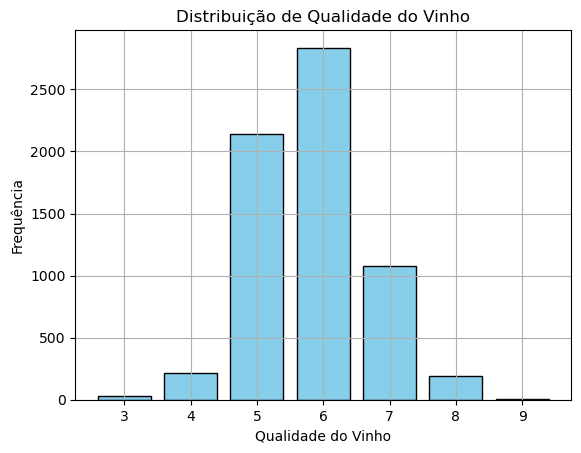

In [25]:
# Plot
value_counts = merged_df['quality'].value_counts().sort_index()
plt.bar(value_counts.index, value_counts.values, color = 'skyblue', edgecolor = 'black')
plt.xlabel('Qualidade do Vinho')
plt.ylabel('Frequência')
plt.title('Distribuição de Qualidade do Vinho')
plt.grid(True)
plt.show()

In [26]:
# Drop da coluna não numérica
numeric_df = merged_df.drop(columns = ['wine_type'])

In [27]:
# Cria a matriz de correlação
correlation_matrix = numeric_df.corr()

In [28]:
# Print da matriz
print("Matriz de Correlação:")
correlation_matrix.head()

Matriz de Correlação:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666


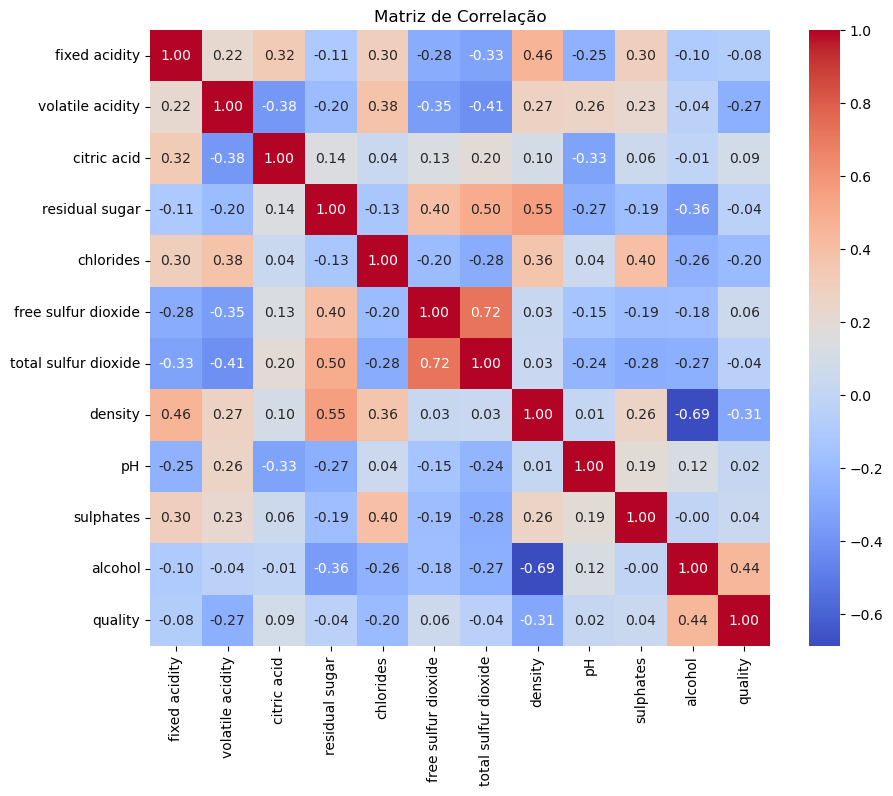

In [29]:
# Plot
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Matriz de Correlação')
plt.show()

In [30]:
# Ordena os dados
quality_correlations = correlation_matrix['quality'].sort_values(ascending = False)

In [31]:
print("Correlação com 'quality':")
print(quality_correlations)

Correlação com 'quality':
quality                 1.000000
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64


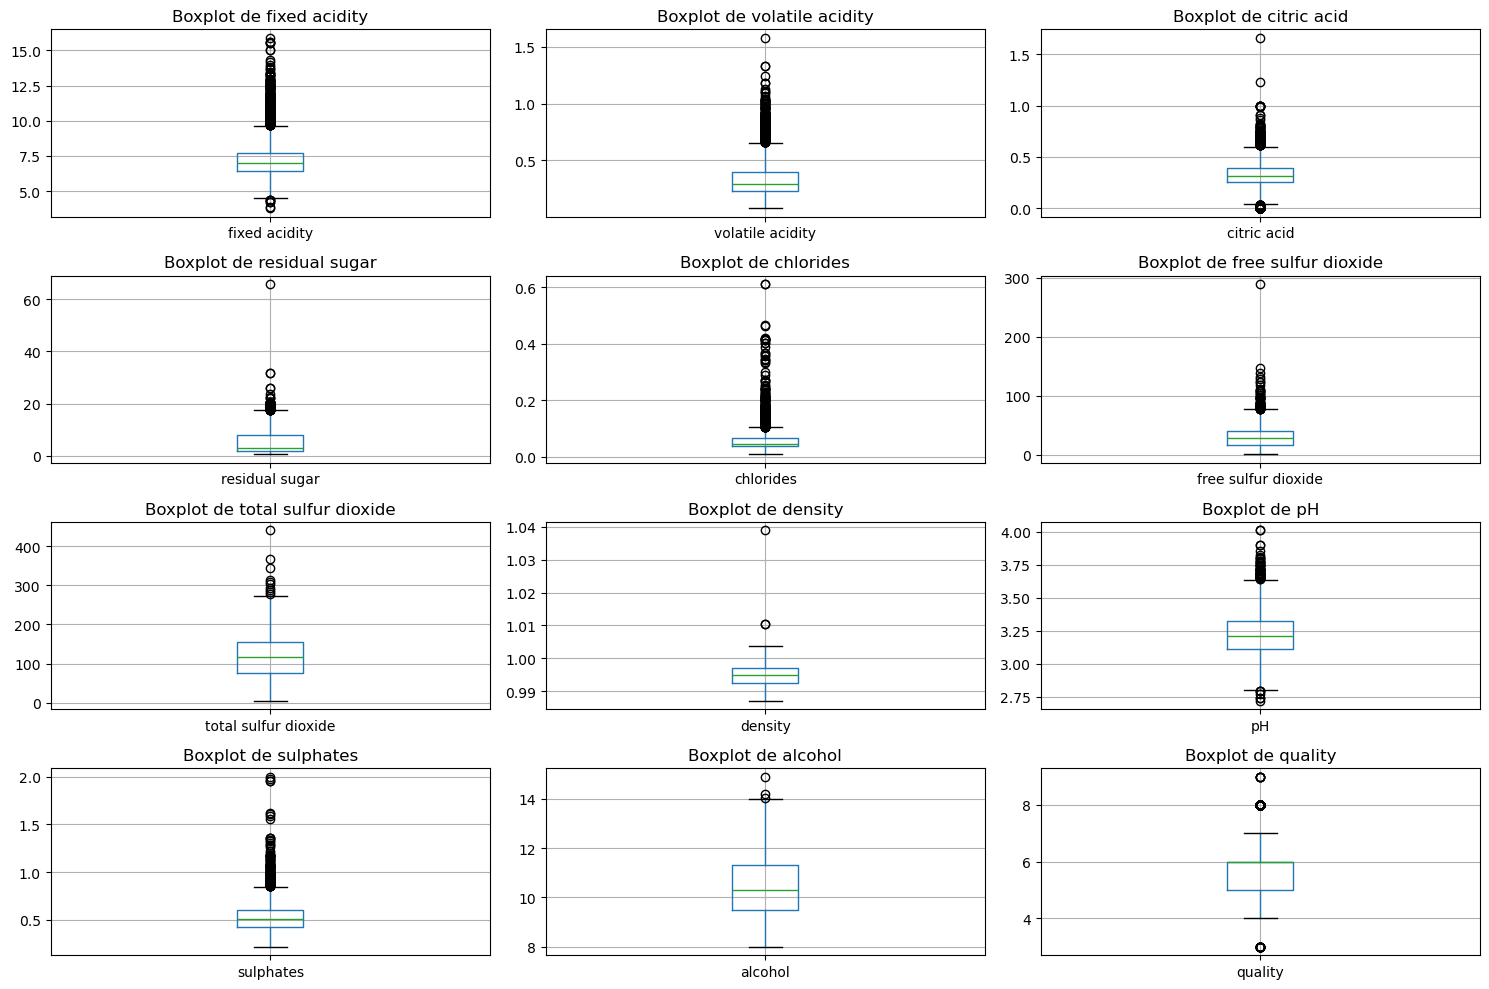

In [32]:
# Plot

num_cols = 3  
num_rows = math.ceil((len(merged_df.columns) - 1) / num_cols)  

# Cria os subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize = (15, 10))

# Flatten dos eixos
axes = axes.flatten()

# Cria um boxplot de cada variável
for i, column in enumerate(merged_df.columns):
    if column != 'wine_type':
        merged_df.boxplot(column=[column], ax=axes[i])
        axes[i].set_title(f'Boxplot de {column}')

# Desliga os eixos não necessários
for j in range(num_rows * num_cols, len(axes)):
    axes[j].axis('off')

# Ajusta o layout
plt.tight_layout()
plt.show()

## Detecção de Outliers

In [33]:
# Seleciona as colunas numéricas para detecção de outliers
numerical_columns = merged_df.select_dtypes(include = [np.number]).columns

In [34]:
# Calcula o Intervalo Interquartil (IQR) de cada variável
Q1 = merged_df[numerical_columns].quantile(0.25)
Q3 = merged_df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

In [35]:
# Define os limites superior e inferior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [36]:
# Identifica potenciais outliers
potential_outliers = ((merged_df[numerical_columns] < lower_bound) | (merged_df[numerical_columns] > upper_bound))

In [37]:
# Filtra o dataframe
outliers_df = merged_df[potential_outliers.any(axis = 1)]

In [38]:
# Conta os outliers de cada variável
outlier_counts = potential_outliers.sum()

In [39]:
outlier_counts

fixed acidity           357
volatile acidity        377
citric acid             509
residual sugar          118
chlorides               286
free sulfur dioxide      62
total sulfur dioxide     10
density                   3
pH                       73
sulphates               191
alcohol                   3
quality                 228
dtype: int64

## Divisão em Dados de Treino, Validação e Teste

In [40]:
dados_treino, dados_temp = train_test_split(merged_df, test_size = 0.3, random_state = 42)

In [41]:
dados_valid, dados_teste = train_test_split(dados_temp, test_size = 0.5, random_state = 42)

## Padronização

In [42]:
dados_treino.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
3761,6.1,0.17,0.28,2.5,0.028,22.0,98.0,0.99072,3.16,0.37,11.1,7.0,white
3740,7.0,0.15,0.28,14.7,0.051,29.0,149.0,0.99792,2.96,0.39,9.0,7.0,white
1359,6.5,0.19,0.32,1.4,0.040,31.0,132.0,0.99220,3.36,0.54,10.8,7.0,white
1230,7.3,0.29,0.30,13.0,0.043,46.0,238.0,0.99860,3.06,0.41,8.7,6.0,white
4751,7.3,0.36,0.62,7.1,0.033,48.0,185.0,0.99472,3.14,0.62,10.6,6.0,white


In [43]:
# Lista de colunas numéricas excluindo a variável alvo (qualidade)
colunas_numericas_treino = dados_treino.select_dtypes(include = [np.number]).drop(columns = ['quality']).columns

In [44]:
# Lista de colunas numéricas excluindo a variável alvo (qualidade)
colunas_numericas_valid = dados_valid.select_dtypes(include = [np.number]).drop(columns = ['quality']).columns

In [45]:
# Lista de colunas numéricas excluindo a variável alvo (qualidade)
colunas_numericas_teste = dados_teste.select_dtypes(include = [np.number]).drop(columns = ['quality']).columns

In [46]:
# Cria o objeto de padronização
scaler = MinMaxScaler()

In [47]:
# Fit e transform em treino
dados_treino[colunas_numericas_treino] = scaler.fit_transform(dados_treino[colunas_numericas_treino])

In [48]:
# Apenas transform em validação
dados_valid[colunas_numericas_valid] = scaler.transform(dados_valid[colunas_numericas_valid])

In [49]:
# Apenas transform em teste
dados_teste[colunas_numericas_teste] = scaler.transform(dados_teste[colunas_numericas_teste])

In [50]:
dados_treino.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
3761,0.190083,0.060000,0.168675,0.061290,0.026711,0.144330,0.255201,0.154942,0.372881,0.080000,0.449275,7.0,white
3740,0.264463,0.046667,0.168675,0.454839,0.065109,0.192440,0.396671,0.465688,0.203390,0.091429,0.144928,7.0,white
1359,0.223140,0.073333,0.192771,0.025806,0.046745,0.206186,0.349515,0.218817,0.542373,0.177143,0.405797,7.0,white
1230,0.289256,0.140000,0.180723,0.400000,0.051753,0.309278,0.643551,0.495037,0.288136,0.102857,0.101449,6.0,white
4751,0.289256,0.186667,0.373494,0.209677,0.035058,0.323024,0.496533,0.327579,0.355932,0.222857,0.376812,6.0,white


In [51]:
dados_valid.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
5169,0.636364,0.066667,0.307229,0.109677,0.153589,0.020619,0.047157,0.538196,0.474576,0.422857,0.304348,6.0,red
6388,0.272727,0.093333,0.295181,0.038710,0.045075,0.048110,0.033287,0.272335,0.567797,0.188571,0.637681,6.0,red
4371,0.264463,0.100000,0.168675,0.067742,0.068447,0.103093,0.238558,0.284420,0.389831,0.188571,0.188406,5.0,white
1414,0.165289,0.060000,0.180723,0.025806,0.041736,0.371134,0.343967,0.162710,0.483051,0.085714,0.478261,6.0,white
1738,0.305785,0.046667,0.228916,0.038710,0.070117,0.123711,0.263523,0.322400,0.440678,0.120000,0.289855,5.0,white


In [52]:
dados_teste.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
4221,0.206612,0.133333,0.204819,0.241935,0.043406,0.295533,0.341193,0.230902,0.457627,0.034286,0.594203,6.0,white
4500,0.330579,0.126667,0.198795,0.058065,0.068447,0.240550,0.468793,0.210186,0.406780,0.182857,0.434783,6.0,white
5589,0.446281,0.560000,0.144578,0.064516,0.125209,0.075601,0.241331,0.546828,0.644068,0.177143,0.260870,5.0,red
2629,0.165289,0.346667,0.000000,0.022581,0.053422,0.487973,0.529820,0.211049,0.711864,0.114286,0.420290,5.0,white
3410,0.421488,0.146667,0.210843,0.129032,0.033389,0.213058,0.393897,0.321536,0.364407,0.125714,0.507246,7.0,white


## Definindo as Variáveis Dummy com One-Hot-Encode

In [53]:
# Cria as variáveis dummy
dados_treino = pd.get_dummies(data = dados_treino, columns = ['wine_type'])

In [54]:
dados_treino.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type_red,wine_type_white
3761,0.190083,0.060000,0.168675,0.061290,0.026711,0.144330,0.255201,0.154942,0.372881,0.080000,0.449275,7.0,False,True
3740,0.264463,0.046667,0.168675,0.454839,0.065109,0.192440,0.396671,0.465688,0.203390,0.091429,0.144928,7.0,False,True
1359,0.223140,0.073333,0.192771,0.025806,0.046745,0.206186,0.349515,0.218817,0.542373,0.177143,0.405797,7.0,False,True
1230,0.289256,0.140000,0.180723,0.400000,0.051753,0.309278,0.643551,0.495037,0.288136,0.102857,0.101449,6.0,False,True
4751,0.289256,0.186667,0.373494,0.209677,0.035058,0.323024,0.496533,0.327579,0.355932,0.222857,0.376812,6.0,False,True


In [55]:
dados_valid = pd.get_dummies(data = dados_valid, columns = ['wine_type'])

In [56]:
dados_teste = pd.get_dummies(data = dados_teste, columns = ['wine_type'])

In [57]:
dados_treino[['wine_type_white', 'wine_type_red']] = dados_treino[['wine_type_white', 'wine_type_red']].astype(int)

In [58]:
dados_treino.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type_red,wine_type_white
3761,0.190083,0.060000,0.168675,0.061290,0.026711,0.144330,0.255201,0.154942,0.372881,0.080000,0.449275,7.0,0,1
3740,0.264463,0.046667,0.168675,0.454839,0.065109,0.192440,0.396671,0.465688,0.203390,0.091429,0.144928,7.0,0,1
1359,0.223140,0.073333,0.192771,0.025806,0.046745,0.206186,0.349515,0.218817,0.542373,0.177143,0.405797,7.0,0,1
1230,0.289256,0.140000,0.180723,0.400000,0.051753,0.309278,0.643551,0.495037,0.288136,0.102857,0.101449,6.0,0,1
4751,0.289256,0.186667,0.373494,0.209677,0.035058,0.323024,0.496533,0.327579,0.355932,0.222857,0.376812,6.0,0,1


In [59]:
dados_valid[['wine_type_white', 'wine_type_red']] = dados_valid[['wine_type_white', 'wine_type_red']].astype(int)

In [60]:
dados_valid.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type_red,wine_type_white
5169,0.636364,0.066667,0.307229,0.109677,0.153589,0.020619,0.047157,0.538196,0.474576,0.422857,0.304348,6.0,1,0
6388,0.272727,0.093333,0.295181,0.038710,0.045075,0.048110,0.033287,0.272335,0.567797,0.188571,0.637681,6.0,1,0
4371,0.264463,0.100000,0.168675,0.067742,0.068447,0.103093,0.238558,0.284420,0.389831,0.188571,0.188406,5.0,0,1
1414,0.165289,0.060000,0.180723,0.025806,0.041736,0.371134,0.343967,0.162710,0.483051,0.085714,0.478261,6.0,0,1
1738,0.305785,0.046667,0.228916,0.038710,0.070117,0.123711,0.263523,0.322400,0.440678,0.120000,0.289855,5.0,0,1


In [61]:
dados_teste[['wine_type_white', 'wine_type_red']] = dados_teste[['wine_type_white', 'wine_type_red']].astype(int)

In [62]:
dados_teste.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type_red,wine_type_white
4221,0.206612,0.133333,0.204819,0.241935,0.043406,0.295533,0.341193,0.230902,0.457627,0.034286,0.594203,6.0,0,1
4500,0.330579,0.126667,0.198795,0.058065,0.068447,0.240550,0.468793,0.210186,0.406780,0.182857,0.434783,6.0,0,1
5589,0.446281,0.560000,0.144578,0.064516,0.125209,0.075601,0.241331,0.546828,0.644068,0.177143,0.260870,5.0,1,0
2629,0.165289,0.346667,0.000000,0.022581,0.053422,0.487973,0.529820,0.211049,0.711864,0.114286,0.420290,5.0,0,1
3410,0.421488,0.146667,0.210843,0.129032,0.033389,0.213058,0.393897,0.321536,0.364407,0.125714,0.507246,7.0,0,1


In [63]:
# Colocamos a variável alvo no começo do dataframe
quality_column = dados_treino['quality']
dados_treino.drop(columns = ['quality'], inplace = True)
dados_treino.insert(0, 'quality', quality_column)

In [64]:
dados_treino.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type_red,wine_type_white
3761,7.0,0.190083,0.060000,0.168675,0.061290,0.026711,0.144330,0.255201,0.154942,0.372881,0.080000,0.449275,0,1
3740,7.0,0.264463,0.046667,0.168675,0.454839,0.065109,0.192440,0.396671,0.465688,0.203390,0.091429,0.144928,0,1
1359,7.0,0.223140,0.073333,0.192771,0.025806,0.046745,0.206186,0.349515,0.218817,0.542373,0.177143,0.405797,0,1
1230,6.0,0.289256,0.140000,0.180723,0.400000,0.051753,0.309278,0.643551,0.495037,0.288136,0.102857,0.101449,0,1
4751,6.0,0.289256,0.186667,0.373494,0.209677,0.035058,0.323024,0.496533,0.327579,0.355932,0.222857,0.376812,0,1


In [65]:
# Colocamos a variável alvo no começo do dataframe
quality_column = dados_valid['quality']
dados_valid.drop(columns = ['quality'], inplace = True)
dados_valid.insert(0, 'quality', quality_column)

In [66]:
dados_valid.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type_red,wine_type_white
5169,6.0,0.636364,0.066667,0.307229,0.109677,0.153589,0.020619,0.047157,0.538196,0.474576,0.422857,0.304348,1,0
6388,6.0,0.272727,0.093333,0.295181,0.038710,0.045075,0.048110,0.033287,0.272335,0.567797,0.188571,0.637681,1,0
4371,5.0,0.264463,0.100000,0.168675,0.067742,0.068447,0.103093,0.238558,0.284420,0.389831,0.188571,0.188406,0,1
1414,6.0,0.165289,0.060000,0.180723,0.025806,0.041736,0.371134,0.343967,0.162710,0.483051,0.085714,0.478261,0,1
1738,5.0,0.305785,0.046667,0.228916,0.038710,0.070117,0.123711,0.263523,0.322400,0.440678,0.120000,0.289855,0,1


In [67]:
# Colocamos a variável alvo no começo do dataframe
quality_column = dados_teste['quality']
dados_teste.drop(columns = ['quality'], inplace = True)
dados_teste.insert(0, 'quality', quality_column)

In [68]:
dados_teste.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type_red,wine_type_white
4221,6.0,0.206612,0.133333,0.204819,0.241935,0.043406,0.295533,0.341193,0.230902,0.457627,0.034286,0.594203,0,1
4500,6.0,0.330579,0.126667,0.198795,0.058065,0.068447,0.240550,0.468793,0.210186,0.406780,0.182857,0.434783,0,1
5589,5.0,0.446281,0.560000,0.144578,0.064516,0.125209,0.075601,0.241331,0.546828,0.644068,0.177143,0.260870,1,0
2629,5.0,0.165289,0.346667,0.000000,0.022581,0.053422,0.487973,0.529820,0.211049,0.711864,0.114286,0.420290,0,1
3410,7.0,0.421488,0.146667,0.210843,0.129032,0.033389,0.213058,0.393897,0.321536,0.364407,0.125714,0.507246,0,1


In [69]:
# Print the shapes of the resulting datasets
print("Shape dos Dados de Treino:", dados_treino.shape)
print("Shape dos Dados de Validação:", dados_valid.shape)
print("Shape dos Dados de Teste:", dados_teste.shape)

Shape dos Dados de Treino: (4547, 14)
Shape dos Dados de Validação: (975, 14)
Shape dos Dados de Teste: (975, 14)


## Converte os Dataframes Para Formato de CSV na Memória

In [70]:
# Converte os dataframes para o formato CSV na memória
dados_treino_buffer = io.StringIO()
dados_treino.to_csv(dados_treino_buffer, index = False)
dados_treino_buffer.seek(0)

dados_valid_buffer = io.StringIO()
dados_valid.to_csv(dados_valid_buffer, index = False)
dados_valid_buffer.seek(0)

dados_teste_buffer = io.StringIO()
dados_teste.to_csv(dados_teste_buffer, index = False)
dados_teste_buffer.seek(0)

0

## Upload Para o S3

Vamos gravar os arquivos processados no S3.

In [71]:
# Upload dos arquivos CSV para S3
s3_client.put_object(Body = dados_treino_buffer.getvalue(), Bucket = bucket_name, Key = 'dados_treino.csv')
s3_client.put_object(Body = dados_valid_buffer.getvalue(), Bucket = bucket_name, Key = 'dados_valid.csv')
s3_client.put_object(Body = dados_teste_buffer.getvalue(), Bucket = bucket_name, Key = 'dados_teste.csv')

{'ResponseMetadata': {'RequestId': 'G3M6PZ16409GSM7A',
  'HostId': 'lRaEUYycs/EYL97xViiU+1LvCw1MVxMzNQuOjr2rYBTstH5XWumL5A5CO22mb1lQWQpuaFW8XHw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'lRaEUYycs/EYL97xViiU+1LvCw1MVxMzNQuOjr2rYBTstH5XWumL5A5CO22mb1lQWQpuaFW8XHw=',
   'x-amz-request-id': 'G3M6PZ16409GSM7A',
   'date': 'Thu, 06 Jun 2024 23:47:26 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"3e4acda566964db4a2c0d93df766b609"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"3e4acda566964db4a2c0d93df766b609"',
 'ServerSideEncryption': 'AES256'}

In [72]:
# Define a role de execução do SageMaker
role = get_execution_role()

In [73]:
# Define o caminho para os arquivos
caminho_dados_treino = f's3://{bucket_name}/dados_treino.csv'
caminho_dados_valid = f's3://{bucket_name}/dados_valid.csv'
caminho_dados_teste = f's3://{bucket_name}/dados_teste.csv'

## Criando o Estimador XGBoost

In [74]:
# Define o estimador com SageMaker
dsa_xgb_estimator = sagemaker.estimator.Estimator(
    image_uri = sagemaker.image_uris.retrieve("xgboost", 
                                              region = sagemaker.Session().boto_region_name, 
                                              version = '1.2-1'),
    role = role,
    instance_count = 1,
    instance_type = 'ml.m5.xlarge',
    output_path = f's3://{bucket_name}/xgboost_otimizado_output',
    deploy_mode = False)

## Definindo o Grid de Hiperparâmetros

In [75]:
# Define o grid de hiperparâmetros para o tuning
grid_hiperparametros = {
    'max_depth': IntegerParameter(4, 7),
    'eta': ContinuousParameter(0.1, 0.4),
    'gamma': ContinuousParameter(0.0, 0.3),
    'min_child_weight': IntegerParameter(1, 5),
    'subsample': ContinuousParameter(0.5, 1),
    'alpha': ContinuousParameter(0, 0.1),
    'lambda': ContinuousParameter(0, 0.1),
    'num_round': IntegerParameter(100, 101)
}

## Otimização dos Hiperparâmetros

In [76]:
# Métrica usada para a otimização
metrica_objetivo = 'validation:rmse'

In [77]:
# Cria o otimizador
dsa_tuner = HyperparameterTuner(estimator = dsa_xgb_estimator,
                                objective_metric_name = metrica_objetivo,
                                objective_type = 'Minimize',  
                                hyperparameter_ranges = grid_hiperparametros,
                                max_jobs = 28,  
                                max_parallel_jobs = 4)

In [78]:
# Cria o input de treino
input_treino = TrainingInput(caminho_dados_treino, content_type = 'text/csv')

In [79]:
# Cria o input de validação
input_valid = TrainingInput(caminho_dados_valid, content_type = 'text/csv')

In [80]:
%%time
dsa_tuner.fit({'train': input_treino, 'validation': input_valid})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................!
CPU times: user 427 ms, sys: 43.3 ms, total: 470 ms
Wall time: 7min 29s


In [81]:
dsa_tuner.stop_tuning_job()

In [82]:
best_training_job_name = dsa_tuner.best_training_job()

In [83]:
# Descrevendo o melhor job de treinamento para obter os hiperparâmetros
best_training_job_info = sagemaker.Session().describe_training_job(job_name = best_training_job_name)

In [84]:
best_hyperparameters = best_training_job_info['HyperParameters']

In [85]:
print("Melhores Hiperparâmetros:")
print(best_hyperparameters)

Melhores Hiperparâmetros:
{'_tuning_objective_metric': 'validation:rmse', 'alpha': '0.008301872248817376', 'eta': '0.167963131613249', 'gamma': '0.05971914859245542', 'lambda': '0.01106648481998912', 'max_depth': '7', 'min_child_weight': '2', 'num_round': '100', 'subsample': '0.9656861487728767'}


In [86]:
# Set dos melhores hiperparâmetros
dsa_xgb_estimator.set_hyperparameters(**best_hyperparameters)

In [87]:
# Treinando a versão final do modelo com os melhores hiperparâmetros
dsa_xgb_estimator.fit({'train': input_treino, 'validation': input_valid}, job_name = 'best-dsa-xgboost-1')

INFO:sagemaker:Creating training-job with name: best-dsa-xgboost-1


2024-06-07 00:43:20 Starting - Starting the training job...
2024-06-07 00:43:36 Starting - Preparing the instances for training...
2024-06-07 00:43:56 Downloading - Downloading input data...
2024-06-07 00:44:21 Downloading - Downloading the training image...
2024-06-07 00:45:20 Training - Training image download completed. Training in progress.
2024-06-07 00:45:20 Uploading - Uploading generated training model
2024-06-07 00:45:20 Completed - Training job completed
[2024-06-07 00:45:03.524 ip-10-0-94-103.us-east-2.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimi

In [88]:
s3_client.download_file(bucket_name, 'xgboost_otimizado_output/best-dsa-xgboost-1/output/model.tar.gz', 'model.tar.gz')

In [89]:
!tar -zxvf model.tar.gz

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
xgboost-model


In [90]:
# Carrega o modelo
with open('xgboost-model', 'rb') as file:
    xgboost_model = pickle.load(file)

[00:51:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181168148/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [91]:
# Extrai os atrobutos e labels
X_test_xgb = dados_teste.drop(columns = ['quality'])
y_test_xgb = dados_teste['quality']

In [92]:
# Converte o dataframe para objeto DMatrix
dtest_xgb = xgb.DMatrix(X_test_xgb)

In [93]:
# Faz as previsões com o modelo XGBoost
predictions_xgboost = xgboost_model.predict(dtest_xgb)
predictions_xgboost_rounded = np.round(predictions_xgboost)

In [94]:
# Calcula as métricas de avaliação do XGBoost com dados de teste
xgboost_metrics = {'MSE (XGBoost)': mean_squared_error(y_test_xgb, predictions_xgboost_rounded),
                   'MAE (XGBoost)': mean_absolute_error(y_test_xgb, predictions_xgboost_rounded),
                   'RMSE (XGBoost)': np.sqrt(mean_squared_error(y_test_xgb, predictions_xgboost_rounded))}

In [95]:
print(xgboost_metrics)

{'MSE (XGBoost)': 0.4564102564102564, 'MAE (XGBoost)': 0.38666666666666666, 'RMSE (XGBoost)': 0.6755814210073101}


In [96]:
# Cria o dataframe com dados reais e previstos
xgboost_results_df = pd.DataFrame({'Real': y_test_xgb, 'Previsto': predictions_xgboost_rounded})
xgboost_results_df.head()

,Real,Previsto
4221,6.0,6.0
4500,6.0,6.0
5589,5.0,5.0
2629,5.0,6.0
3410,7.0,6.0


In [97]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [98]:
#%watermark -v -m

In [99]:
#%watermark --iversions

# Fim